Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


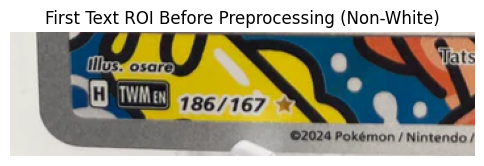

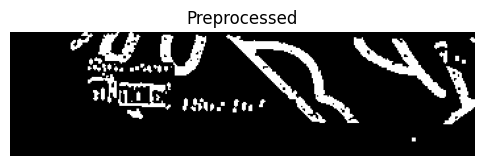

OCR result: ['EV', 'Tzc', '1au:']


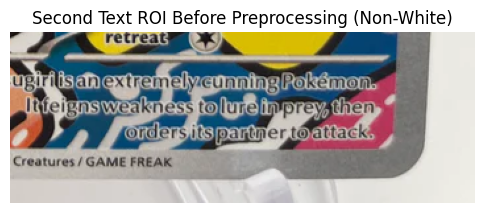

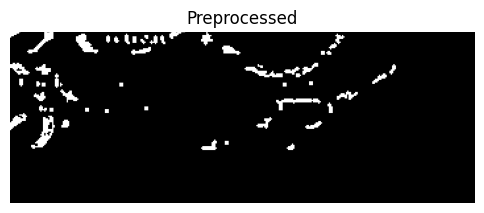

OCR result: []
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Model Prediction: ROI Bottom Left, Class: McDonald's Collection 2019, Confidence: 1.0000


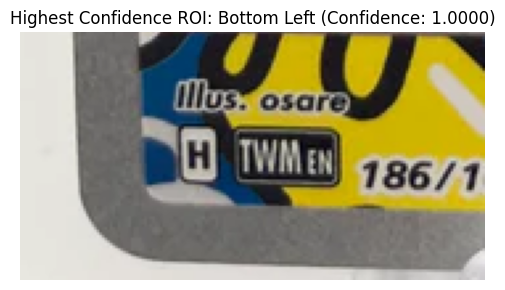

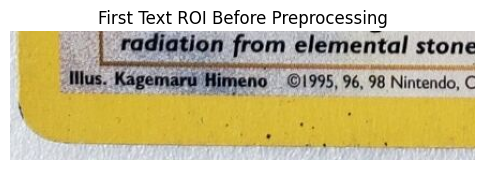

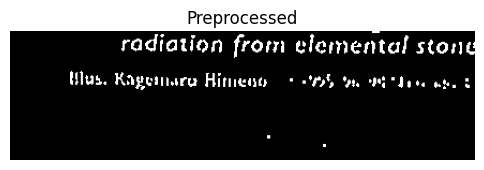

OCR result: ['radiation from elcmental stone', 'Hlus', 'Kagetllwru Hirneutr']


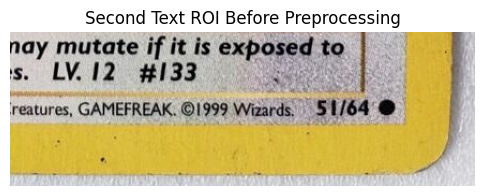

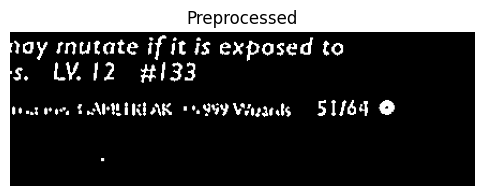

OCR result: ['ay rnutate if it is exposed to', 'LV: 12', '#133', "Mimak '95y Vxuat Is", '51/64 0']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Model Prediction: ROI Bottom Left, Class: POP Series 5, Confidence: 1.0000


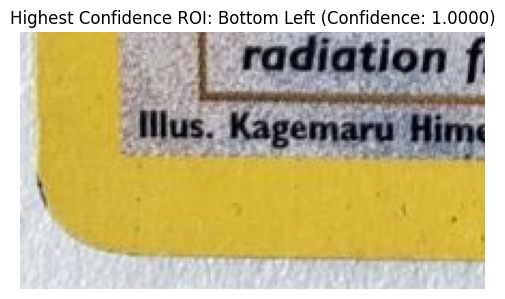

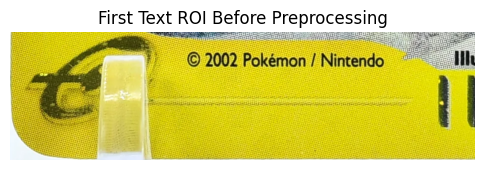

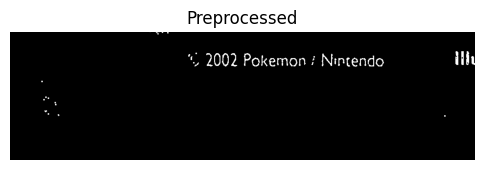

OCR result: ['2002 Pokemon', 'Ninrendo']


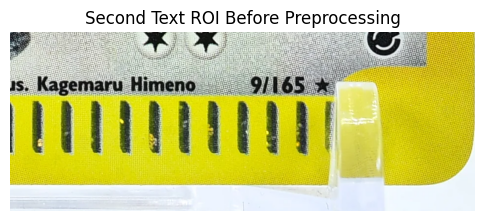

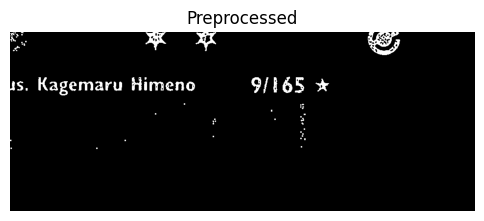

OCR result: ['JS,', 'Kagemaru Himeno', '9/165']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Model Prediction: ROI Bottom Left, Class: Base, Confidence: 1.0000


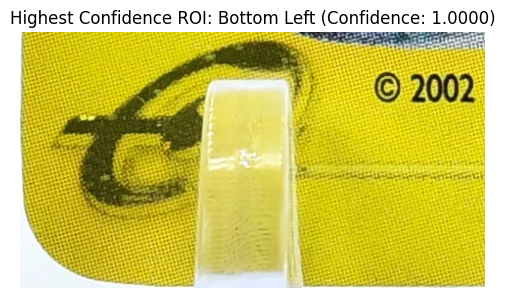

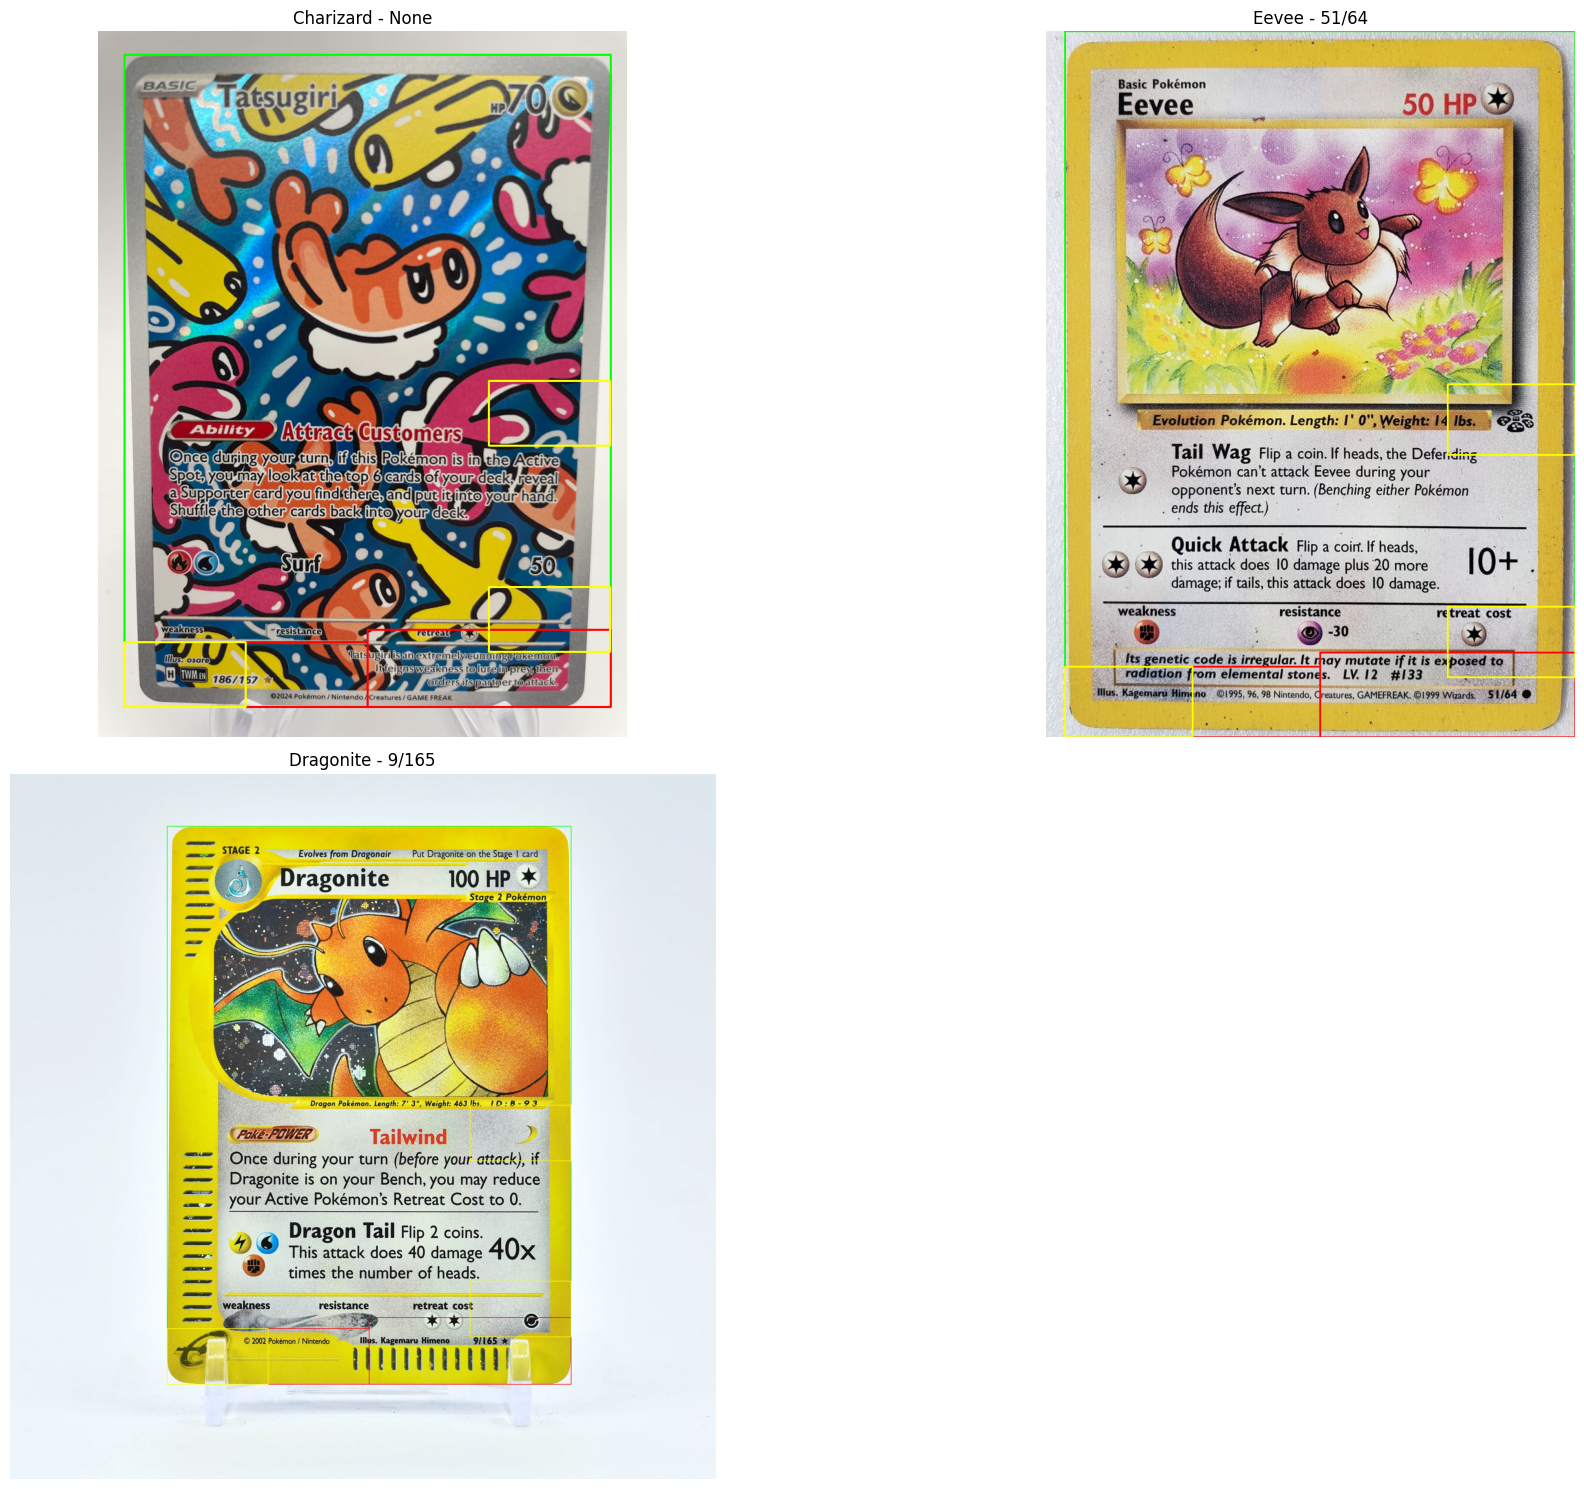

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
from PIL import Image
from collections import Counter
import re
from tensorflow.keras.models import load_model
import json

# Load the saved model
model = load_model(r"C:\Users\Jimmy\Desktop\final-project\PokemonTCG\models\model04.keras")

# Load the class names (saved class indices from JSON file)
with open(r'C:\Users\Jimmy\Desktop\final-project\class_indices.json', 'r') as f:
    class_indices = json.load(f)

# Reverse the dictionary to map numeric labels to class names
class_names = {v: k for k, v in class_indices.items()}

# Initialize EasyOCR reader (use 'en' for English)
reader = easyocr.Reader(['en'])

# Function to classify a card as white or non-white
def classify_card(image_rgb):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    mean_brightness = np.mean(gray)
    
    if mean_brightness > 150:
        return "white"
    else:
        return "non_white"


# Function to adjust brightness and contrast
def adjust_brightness_contrast(image, alpha=2, beta=25):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)


# Function to display images for debugging
def debug_show_image(image, title="Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


# Preprocessing to identify all colors that are not black and turn them into white
def ocr_preprocessing1(image_roi):
    roi_gray = cv2.cvtColor(image_roi, cv2.COLOR_BGR2GRAY)
    _, roi_thresh_black = cv2.threshold(roi_gray, 30, 255, cv2.THRESH_BINARY)
    
    roi_contrast = adjust_brightness_contrast(roi_thresh_black, alpha=1.5, beta=30)
    roi_blur = cv2.GaussianBlur(roi_contrast, (3, 3), 0)
    roi_thresh = cv2.adaptiveThreshold(roi_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
    roi_sharpen = cv2.filter2D(roi_thresh, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
    
    debug_show_image(roi_sharpen, title="Preprocessed")
    return roi_sharpen


# OCR processing with EasyOCR
def perform_ocr_easyocr(image_roi):
    # Perform OCR using EasyOCR
    result = reader.readtext(image_roi, detail=0)
    print(f"OCR result: {result}")
    
    return result

# Function to process OCR results and select only the valid match
def process_ocr_results(ocr_results):
    # Define the patterns for the two cases
    pattern_letters_digits = r'[a-zA-Z]{2,4}\d{1,3}'  # 2-4 letters followed by 1-3 numbers
    pattern_numbers_slash = r'\d{1,3}/\d{2,3}'  # 1-3 numbers followed by / and 2-3 numbers

    for result in ocr_results:
        # Try to match both patterns
        match_letters_digits = re.search(pattern_letters_digits, result)
        match_numbers_slash = re.search(pattern_numbers_slash, result)

        # Return only the matched portion, if found
        if match_letters_digits:
            return match_letters_digits.group()  # Return the first valid match for letters-digits
        elif match_numbers_slash:
            return match_numbers_slash.group()  # Return the first valid match for numbers-slash

    return None  # Return None if no valid match is found

def convert_non_black_to_white(roi):
    """
    Converts all non-black pixels in the ROI to white, keeping the image in RGB format.
    """
    # Threshold to detect non-black pixels (any pixel not close to [0, 0, 0])
    non_black_mask = np.any(roi > [30, 30, 30], axis=-1)  # You can adjust the threshold value

    # Create a copy of the ROI
    processed_roi = roi.copy()

    # Set non-black pixels to white
    processed_roi[non_black_mask] = [255, 255, 255]  # Turn non-black areas to white

    return processed_roi

# Function to apply the model to all three ROIs and rank by confidence score
def apply_model_to_rois(model, roi_bottom_left, roi_bottom_right, roi_middle):
    roi_bottom_left_processed = convert_non_black_to_white(roi_bottom_left)
    roi_bottom_right_processed = convert_non_black_to_white(roi_bottom_right)
    roi_middle_processed = convert_non_black_to_white(roi_middle)

    if len(roi_bottom_left_processed.shape) == 2:
        roi_bottom_left_processed = cv2.cvtColor(roi_bottom_left_processed, cv2.COLOR_GRAY2RGB)
    if len(roi_bottom_right_processed.shape) == 2:
        roi_bottom_right_processed = cv2.cvtColor(roi_bottom_right_processed, cv2.COLOR_GRAY2RGB)
    if len(roi_middle_processed.shape) == 2:
        roi_middle_processed = cv2.cvtColor(roi_middle_processed, cv2.COLOR_GRAY2RGB)

    roi_bottom_left_resized = cv2.resize(roi_bottom_left_processed, (150, 150))
    roi_bottom_right_resized = cv2.resize(roi_bottom_right_processed, (150, 150))
    roi_middle_resized = cv2.resize(roi_middle_processed, (150, 150))

    roi_bottom_left_exp = np.expand_dims(roi_bottom_left_resized, axis=0)
    roi_bottom_right_exp = np.expand_dims(roi_bottom_right_resized, axis=0)
    roi_middle_exp = np.expand_dims(roi_middle_resized, axis=0)

    prediction_bottom_left = model.predict(roi_bottom_left_exp)
    prediction_bottom_right = model.predict(roi_bottom_right_exp)
    prediction_middle = model.predict(roi_middle_exp)

    confidence_bottom_left = np.max(prediction_bottom_left)
    class_bottom_left = np.argmax(prediction_bottom_left)

    confidence_bottom_right = np.max(prediction_bottom_right)
    class_bottom_right = np.argmax(prediction_bottom_right)

    confidence_middle = np.max(prediction_middle)
    class_middle = np.argmax(prediction_middle)

    # Map class index to class name
    class_name_bottom_left = class_names.get(class_bottom_left, "Unknown")
    class_name_bottom_right = class_names.get(class_bottom_right, "Unknown")
    class_name_middle = class_names.get(class_middle, "Unknown")

    results = [
        (confidence_bottom_left, class_name_bottom_left, 'Bottom Left'),
        (confidence_bottom_right, class_name_bottom_right, 'Bottom Right'),
        (confidence_middle, class_name_middle, 'Middle')
    ]

    results_sorted = sorted(results, key=lambda x: x[0], reverse=True)
    return results_sorted




# Function to extract bounding boxes and run OCR on white cards
def draw_bounding_box_white(image_bgr, model):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # --- First Text ROI (for OCR) ---
        text_roi_height = h // 10
        text_roi_width = int(w * 0.5)
        text_roi_y_start = y + h - text_roi_height
        first_text_roi = image_bgr[text_roi_y_start:text_roi_y_start + text_roi_height, x:x + text_roi_width]

        # Debugging: show the first ROI before preprocessing
        debug_show_image(first_text_roi, title="First Text ROI Before Preprocessing")

        processed_first_text_roi = ocr_preprocessing1(first_text_roi)
        ocr_results_first = perform_ocr_easyocr(processed_first_text_roi)

        # --- Second Text ROI ---
        second_text_roi_height = int(text_roi_height * 1.2)
        second_text_roi_x_start = x + w - text_roi_width
        second_text_roi_y_start = y + h - second_text_roi_height
        second_text_roi = image_bgr[second_text_roi_y_start:text_roi_y_start + second_text_roi_height,
                                    second_text_roi_x_start:second_text_roi_x_start + text_roi_width]

        # Debugging: show the second ROI before preprocessing
        debug_show_image(second_text_roi, title="Second Text ROI Before Preprocessing")

        processed_second_text_roi = ocr_preprocessing1(second_text_roi)
        ocr_results_second = perform_ocr_easyocr(processed_second_text_roi)

        # --- Decision: Keep only one OCR result ---
        processed_ocr_result_first = process_ocr_results(ocr_results_first)
        processed_ocr_result_second = process_ocr_results(ocr_results_second)

        final_ocr_result = processed_ocr_result_first if processed_ocr_result_first else processed_ocr_result_second

        # --- Set Symbol ROIs ---
        roi_bottom_left_coords = (x, y + h - text_roi_height, w // 4, text_roi_height)
        roi_middle_coords = (x + 3 * w // 4, y + h // 2, w // 4, text_roi_height)
        roi_bottom_right_y_adjusted = y + h - 2 * text_roi_height + int(0.15 * text_roi_height)
        roi_bottom_right_coords = (x + w // 2 + w // 4, roi_bottom_right_y_adjusted, w // 4, text_roi_height)

        # Extract ROIs based on the coordinates
        roi_bottom_left = image_bgr[roi_bottom_left_coords[1]:roi_bottom_left_coords[1] + roi_bottom_left_coords[3],
                                    roi_bottom_left_coords[0]:roi_bottom_left_coords[0] + roi_bottom_left_coords[2]]
        roi_middle = image_bgr[roi_middle_coords[1]:roi_middle_coords[1] + roi_middle_coords[3],
                            roi_middle_coords[0]:roi_middle_coords[0] + roi_middle_coords[2]]
        roi_bottom_right = image_bgr[roi_bottom_right_coords[1]:roi_bottom_right_coords[1] + roi_bottom_right_coords[3],
                                    roi_bottom_right_coords[0]:roi_bottom_right_coords[0] + roi_bottom_right_coords[2]]

        # Apply model to each ROI (actual extracted ROIs, not coordinates)
        results = apply_model_to_rois(model, roi_bottom_left, roi_bottom_right, roi_middle)

        # Get the highest confidence prediction
        best_prediction = results[0]
        confidence, predicted_class, roi_name = best_prediction
        
        # Print or log the model's result
        print(f"Model Prediction: ROI {roi_name}, Class: {predicted_class}, Confidence: {confidence:.4f}")

        # Display the highest confidence ROI immediately
        highest_conf_roi = None
        if roi_name == 'Bottom Left':
            highest_conf_roi = roi_bottom_left
        elif roi_name == 'Bottom Right':
            highest_conf_roi = roi_bottom_right
        else:
            highest_conf_roi = roi_middle

        # Display the highest confidence ROI using matplotlib
        plt.figure(figsize=(6, 6))
        plt.imshow(highest_conf_roi)
        plt.title(f"Highest Confidence ROI: {roi_name} (Confidence: {confidence:.4f})")
        plt.axis('off')
        plt.show()

        # Draw all ROIs and bounding boxes on the original image (use the same coordinates)
        image_with_rois = image_bgr.copy()
        cv2.rectangle(image_with_rois, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Bounding box around the entire object

        # Draw the first text ROI (blue)
        cv2.rectangle(image_with_rois, (x, text_roi_y_start), (x + text_roi_width, text_roi_y_start + text_roi_height), (255, 0, 0), 2)

        # Draw the second text ROI (red)
        cv2.rectangle(image_with_rois, (second_text_roi_x_start, second_text_roi_y_start), 
                    (second_text_roi_x_start + text_roi_width, second_text_roi_y_start + second_text_roi_height), (255, 0, 0), 2)

        # Draw the three set symbol ROIs (yellow), using the same coordinates from the extracted ROIs
        cv2.rectangle(image_with_rois, (roi_bottom_left_coords[0], roi_bottom_left_coords[1]),
                    (roi_bottom_left_coords[0] + roi_bottom_left_coords[2], roi_bottom_left_coords[1] + roi_bottom_left_coords[3]), (255, 255, 0), 2)

        cv2.rectangle(image_with_rois, (roi_bottom_right_coords[0], roi_bottom_right_coords[1]),
                    (roi_bottom_right_coords[0] + roi_bottom_right_coords[2], roi_bottom_right_coords[1] + roi_bottom_right_coords[3]), (255, 255, 0), 2)

        cv2.rectangle(image_with_rois, (roi_middle_coords[0], roi_middle_coords[1]),
                    (roi_middle_coords[0] + roi_middle_coords[2], roi_middle_coords[1] + roi_middle_coords[3]), (255, 255, 0), 2)

        return image_with_rois, final_ocr_result

    else:
        print("No contours found.")
        return image_bgr, None



# Function to extract bounding boxes and run OCR on non-white cards
def draw_bounding_boxes(image_rgb, threshold_value, model):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    _, thresholded = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # --- First Text ROI ---
        text_roi_height = h // 10
        text_roi_width = int(w * 0.5)
        text_roi_y_start = y + h - text_roi_height
        first_text_roi = image_rgb[text_roi_y_start:text_roi_y_start + text_roi_height, x:x + text_roi_width]

        # Debugging: show the first ROI before preprocessing
        debug_show_image(first_text_roi, title="First Text ROI Before Preprocessing (Non-White)")

        processed_first_text_roi = ocr_preprocessing1(first_text_roi)
        ocr_results_first = perform_ocr_easyocr(processed_first_text_roi)

        # --- Second Text ROI ---
        second_text_roi_height = int(text_roi_height * 1.2)
        second_text_roi_x_start = x + w - text_roi_width
        second_text_roi_y_start = y + h - second_text_roi_height
        second_text_roi = image_rgb[second_text_roi_y_start:text_roi_y_start + second_text_roi_height,
                                    second_text_roi_x_start:second_text_roi_x_start + text_roi_width]

        # Debugging: show the second ROI before preprocessing
        debug_show_image(second_text_roi, title="Second Text ROI Before Preprocessing (Non-White)")

        processed_second_text_roi = ocr_preprocessing1(second_text_roi)
        ocr_results_second = perform_ocr_easyocr(processed_second_text_roi)

        # --- Decision: Keep only one OCR result ---
        processed_ocr_result_first = process_ocr_results(ocr_results_first)
        processed_ocr_result_second = process_ocr_results(ocr_results_second)

        final_ocr_result = processed_ocr_result_first if processed_ocr_result_first else processed_ocr_result_second

        # --- Set Symbol ROIs ---
        roi_bottom_left_coords = (x, y + h - text_roi_height, w // 4, text_roi_height)
        roi_middle_coords = (x + 3 * w // 4, y + h // 2, w // 4, text_roi_height)
        roi_bottom_right_y_adjusted = y + h - 2 * text_roi_height + int(0.15 * text_roi_height)
        roi_bottom_right_coords = (x + w // 2 + w // 4, roi_bottom_right_y_adjusted, w // 4, text_roi_height)

        # Extract ROIs based on the coordinates
        roi_bottom_left = image_rgb[roi_bottom_left_coords[1]:roi_bottom_left_coords[1] + roi_bottom_left_coords[3],
                                    roi_bottom_left_coords[0]:roi_bottom_left_coords[0] + roi_bottom_left_coords[2]]
        roi_middle = image_rgb[roi_middle_coords[1]:roi_middle_coords[1] + roi_middle_coords[3],
                            roi_middle_coords[0]:roi_middle_coords[0] + roi_middle_coords[2]]
        roi_bottom_right = image_rgb[roi_bottom_right_coords[1]:roi_bottom_right_coords[1] + roi_bottom_right_coords[3],
                                    roi_bottom_right_coords[0]:roi_bottom_right_coords[0] + roi_bottom_right_coords[2]]

        # Apply model to each ROI (actual extracted ROIs, not coordinates)
        results = apply_model_to_rois(model, roi_bottom_left, roi_bottom_right, roi_middle)

        # Get the highest confidence prediction
        best_prediction = results[0]
        confidence, predicted_class, roi_name = best_prediction
        
        # Print or log the model's result
        print(f"Model Prediction: ROI {roi_name}, Class: {predicted_class}, Confidence: {confidence:.4f}")

        # Display the highest confidence ROI immediately
        highest_conf_roi = None
        if roi_name == 'Bottom Left':
            highest_conf_roi = roi_bottom_left
        elif roi_name == 'Bottom Right':
            highest_conf_roi = roi_bottom_right
        else:
            highest_conf_roi = roi_middle

        # Display the highest confidence ROI using matplotlib
        plt.figure(figsize=(6, 6))
        plt.imshow(highest_conf_roi)
        plt.title(f"Highest Confidence ROI: {roi_name} (Confidence: {confidence:.4f})")
        plt.axis('off')
        plt.show()

        # Draw all ROIs and bounding boxes on the original image (use the same coordinates)
        image_with_rois = image_rgb.copy()
        cv2.rectangle(image_with_rois, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Bounding box around the entire object

        # Draw the first text ROI (blue)
        cv2.rectangle(image_with_rois, (x, text_roi_y_start), (x + text_roi_width, text_roi_y_start + text_roi_height), (255, 0, 0), 2)

        # Draw the second text ROI (red)
        cv2.rectangle(image_with_rois, (second_text_roi_x_start, second_text_roi_y_start), 
                    (second_text_roi_x_start + text_roi_width, second_text_roi_y_start + second_text_roi_height), (255, 0, 0), 2)

        # Draw the three set symbol ROIs (yellow), using the same coordinates from the extracted ROIs
        cv2.rectangle(image_with_rois, (roi_bottom_left_coords[0], roi_bottom_left_coords[1]),
                    (roi_bottom_left_coords[0] + roi_bottom_left_coords[2], roi_bottom_left_coords[1] + roi_bottom_left_coords[3]), (255, 255, 0), 2)

        cv2.rectangle(image_with_rois, (roi_bottom_right_coords[0], roi_bottom_right_coords[1]),
                    (roi_bottom_right_coords[0] + roi_bottom_right_coords[2], roi_bottom_right_coords[1] + roi_bottom_right_coords[3]), (255, 255, 0), 2)

        cv2.rectangle(image_with_rois, (roi_middle_coords[0], roi_middle_coords[1]),
                    (roi_middle_coords[0] + roi_middle_coords[2], roi_middle_coords[1] + roi_middle_coords[3]), (255, 255, 0), 2)

        return image_with_rois, final_ocr_result

    else:
        print("No contours found.")
        return image_rgb, None


# Main function to handle both white and non-white cards
def bounding_box_roi(image_rgb, model):
    card_type = classify_card(image_rgb)

    if card_type == "white":
        # Handle white cards
        image_with_bounding_box, ocr_result= draw_bounding_box_white(image_rgb, model)
    else:
        # Handle non-white cards
        threshold_value = 160
        image_with_bounding_box, ocr_result= draw_bounding_boxes(image_rgb, threshold_value, model)

    return image_with_bounding_box, ocr_result


# Test with the images (replace with actual image paths)
charizard_rgb = cv2.imread(r'C:\Users\Jimmy\Desktop\cb-ds-19\00_Projects\ds-final-project-main\Test Image\IMG_1535_1024x1024.webp')  # Replace with actual path
charizard_rgb = cv2.cvtColor(charizard_rgb, cv2.COLOR_BGR2RGB)  # Ensure correct format

eevee_rgb = cv2.imread(r'C:\Users\Jimmy\Desktop\cb-ds-19\00_Projects\ds-final-project-main\Test Image\s-l1200.jpg')  # Replace with actual path
eevee_rgb = cv2.cvtColor(eevee_rgb, cv2.COLOR_BGR2RGB)  # Ensure correct format

dragonite_rgb = cv2.imread(r'C:\Users\Jimmy\Desktop\cb-ds-19\00_Projects\ds-final-project-main\Test Image\e-reader.webp')  # Replace with actual path
dragonite_rgb = cv2.cvtColor(dragonite_rgb, cv2.COLOR_BGR2RGB)  # Ensure correct format

# Apply the dynamic threshold function to all images
charizard_output, charizard_ocr_results= bounding_box_roi(charizard_rgb, model)
eevee_output, eevee_ocr_results= bounding_box_roi(eevee_rgb, model)
dragonite_output, dragonite_ocr_results= bounding_box_roi(dragonite_rgb, model)


# Display the results for all cards with classification
plt.figure(figsize=(20, 15))

# Charizard
plt.subplot(2, 2, 1)
plt.imshow(charizard_output)
plt.title(f"Charizard - {charizard_ocr_results}")
plt.axis("off")


# Eevee
plt.subplot(2, 2, 2)
plt.imshow(eevee_output)
plt.title(f"Eevee - {eevee_ocr_results}")
plt.axis("off")

# Dragonite
plt.subplot(2, 2, 3)
plt.imshow(dragonite_output)
plt.title(f"Dragonite - {dragonite_ocr_results}")
plt.axis("off")

plt.tight_layout()
plt.show()



In [5]:
import os
import psycopg2

# Database connection
def get_read_only_connection():
    conn = psycopg2.connect(
        host="localhost",
        database="pokemontcg",
        user="readonly_user",
        password="D8G*pBDz*koJ"
    )
    return conn

def get_logging_connection():
    conn = psycopg2.connect(
        host="localhost",
        database="pokemontcg",
        user=os.getenv("PG_LOGGING_USER"),
        password=os.getenv("PG_LOGGING_PASSWORD")
    )
    return conn

# Function to log the user's activity
def log_user_activity(username):
    conn = get_logging_connection()
    cursor = conn.cursor()
    
    insert_query = """
    INSERT INTO restricted_logs.user_logs (username, login_time)
    VALUES (%s, CURRENT_TIMESTAMP);
    """
    cursor.execute(insert_query, (username,))
    
    conn.commit()
    cursor.close()
    conn.close()

# Function to extract YYY from OCR result
def extract_yyy_from_ocr(ocr_result):
    try:
        return ocr_result.split("/")[1]  # Extracts YYY part
    except IndexError:
        return None

# Function to extract XXX from OCR result
def extract_xxx_from_ocr(ocr_result):
    try:
        return ocr_result.split("/")[0]  # Extracts XXX part
    except IndexError:
        return None

# Function to query the database and get the set and card information using read-only connection
def get_set_and_card_info(ocr_result):
    # Extract YYY (printed_total) and XXX (card_number)
    yyy_value = extract_yyy_from_ocr(ocr_result)
    xxx_value = extract_xxx_from_ocr(ocr_result)
    
    if not yyy_value or not xxx_value:
        print("Invalid OCR result format")
        return None

    # Connect to the PostgreSQL database with readonly connection
    conn = get_read_only_connection()
    cur = conn.cursor()

    try:
        # Query the pokemon_sets table to find the id and name based on printed_total (YYY)
        cur.execute("SELECT id, name FROM public.pokemon_sets WHERE printed_total = %s", (yyy_value,))
        set_result = cur.fetchone()

        if not set_result:
            print(f"No set found with printed_total = {yyy_value}")
            return None

        set_id, set_name = set_result

        # Query the table with the same name as the set id to find the card name
        table_name = f'public."{set_id}"'
        cur.execute(f"SELECT card_name FROM {table_name} WHERE card_number = %s", (xxx_value,))
        card_result = cur.fetchone()

        if not card_result:
            print(f"No card found with card_number = {xxx_value} in set {set_name}")
            return None

        card_name = card_result[0]

        # Return the set name, card name, and OCR result
        return {"Set": set_name, "Card": card_name, "OCR_Result": ocr_result}

    finally:
        cur.close()
        conn.close()

# Example usage:
ocr_results = {
    "Charizard": charizard_ocr_results,
    "Eevee": eevee_ocr_results,
    "Dragonite": dragonite_ocr_results
}

# Assuming username is provided during the session
username = "test_user"  # Example username

# Log user activity
log_user_activity(username)

# Perform queries for each OCR result
for card_name, ocr_result in ocr_results.items():
    result = get_set_and_card_info(ocr_result)
    if result:
        print(f"Set: {result['Set']}, Card: {result['Card']}, OCR Result: {result['OCR_Result']}")


Set: Expedition Base Set, Card: Charizard, OCR Result: 39/165
Set: Jungle, Card: Eevee, OCR Result: 51/64
Set: Expedition Base Set, Card: Dragonite, OCR Result: 9/165


In [12]:
import os
import psycopg2

# Database connection
def get_read_only_connection():
    conn = psycopg2.connect(
        host="localhost",
        database="pokemontcg",
        user="readonly_user",
        password="D8G*pBDz*koJ"
    )
    return conn

def get_logging_connection():
    conn = psycopg2.connect(
        host="localhost",
        database="pokemontcg",
        user=os.getenv("PG_LOGGING_USER"),
        password=os.getenv("PG_LOGGING_PASSWORD")
    )
    return conn

# Function to log the user's activity
def log_user_activity(username):
    conn = get_logging_connection()
    cursor = conn.cursor()
    
    insert_query = """
    INSERT INTO restricted_logs.user_logs (username, login_time)
    VALUES (%s, CURRENT_TIMESTAMP);
    """
    cursor.execute(insert_query, (username,))
    
    conn.commit()
    cursor.close()
    conn.close()

# Function to extract YYY from OCR result
def extract_yyy_from_ocr(ocr_result):
    if '/' in ocr_result:
        return ocr_result.split("/")[1]  # Extracts YYY part
    return None

# Function to extract XXX from OCR result
def extract_xxx_from_ocr(ocr_result):
    if '/' in ocr_result:
        return ocr_result.split("/")[0]  # Extracts XXX part
    return ocr_result  # Return the entire string if no slash is present

# Function to handle AAAXXX format
def handle_aaaxxx_format(ocr_result, conn, cur):
    # Extract letters and digits from AAAXXX format
    letters = ''.join(filter(str.isalpha, ocr_result))
    digits = ''.join(filter(str.isdigit, ocr_result))

    if not letters or not digits:
        print("Invalid AAAXXX format")
        return None

    # Determine the table to query based on letters
    table_id = f"{letters.lower()}p"
    if letters.upper() == "HGSS":
        table_id = "hsp"

    # Query the pokemon_sets table to find the id and name
    cur.execute("SELECT id, name FROM public.pokemon_sets WHERE LOWER(id) = %s", (table_id,))
    set_result = cur.fetchone()

    if not set_result:
        print(f"No set found for id = {table_id}")
        return None

    set_id, set_name = set_result

    # Query the table with the same name as the set id to find the card name
    table_name = f'public."{set_id}"'
    cur.execute(f"SELECT card_name FROM {table_name} WHERE card_number = %s", (ocr_result,))
    card_result = cur.fetchone()

    if not card_result:
        print(f"No card found with card_number = {ocr_result} in set {set_name}")
        return None

    card_name = card_result[0]
    return {"Set": set_name, "Card": card_name, "OCR_Result": ocr_result}

# Function to query the database and get the set and card information using read-only connection
def get_set_and_card_info(ocr_result):
    # Connect to the PostgreSQL database with readonly connection
    conn = get_read_only_connection()
    cur = conn.cursor()

    try:
        # Handle XXX/YYY format
        if '/' in ocr_result:
            yyy_value = extract_yyy_from_ocr(ocr_result)
            xxx_value = extract_xxx_from_ocr(ocr_result)

            if not yyy_value or not xxx_value:
                print("Invalid OCR result format")
                return None

            # Query the pokemon_sets table to find the id and name based on printed_total (YYY)
            cur.execute("SELECT id, name FROM public.pokemon_sets WHERE printed_total = %s", (yyy_value,))
            set_result = cur.fetchone()

            if not set_result:
                print(f"No set found with printed_total = {yyy_value}")
                return None

            set_id, set_name = set_result

            # Query the table with the same name as the set id to find the card name
            table_name = f'public."{set_id}"'
            cur.execute(f"SELECT card_name FROM {table_name} WHERE card_number = %s", (xxx_value,))
            card_result = cur.fetchone()

            if not card_result:
                print(f"No card found with card_number = {xxx_value} in set {set_name}")
                return None

            card_name = card_result[0]
            return {"Set": set_name, "Card": card_name, "OCR_Result": ocr_result}

        # Handle AAAXXX format or purely numeric string
        elif ocr_result.isdigit() or ocr_result.isalnum():
            return handle_aaaxxx_format(ocr_result, conn, cur)

        else:
            print(f"Unrecognized OCR result format: {ocr_result}")
            return None

    finally:
        cur.close()
        conn.close()

# Example usage:
ocr_results = {
    "Charizard": charizard_ocr_results,
    "Eevee": eevee_ocr_results,
    "Dragonite": dragonite_ocr_results,
    "Sample1": "SM123",
    "Sample2": "HGSS03"
}

# Assuming username is provided during the session
username = "test_user"  # Example username

# Log user activity
log_user_activity(username)

# Perform queries for each OCR result
for card_name, ocr_result in ocr_results.items():
    result = get_set_and_card_info(ocr_result)
    if result:
        print(f"Set: {result['Set']}, Card: {result['Card']}, OCR Result: {result['OCR_Result']}")


Set: Expedition Base Set, Card: Charizard, OCR Result: 39/165
Set: Jungle, Card: Eevee, OCR Result: 51/64
Set: Expedition Base Set, Card: Dragonite, OCR Result: 9/165
Set: SM Black Star Promos, Card: Dawn Wings Necrozma, OCR Result: SM123
Set: HGSS Black Star Promos, Card: Pikachu, OCR Result: HGSS03


In [7]:
# Import necessary modules
import streamlit as st
import cv2
from PIL import Image
import json
import pandas as pd
import psycopg2
import os
import easyocr
from tensorflow.keras.models import load_model
import numpy as np


# --- LOAD MODEL ---
# Load the pretrained Keras model for symbol recognition
model = load_model(r"C:\Users\Jimmy\Desktop\final-project\PokemonTCG\models\model04.keras")

# Load the class names (saved class indices from JSON file)
with open(r'C:\Users\Jimmy\Desktop\final-project\class_indices.json', 'r') as f:
    class_indices = json.load(f)

# Reverse the dictionary to map numeric labels to class names
class_names = {v: k for k, v in class_indices.items()}



# --- LOAD OCR ---
# Initialize EasyOCR reader (use 'en' for English)
reader = easyocr.Reader(['en'])



# --- LOAD POSTGRESQL CONNECTION
# Function to create a PostgreSQL connection as the readonly user for querying
def get_read_only_connection():
    conn = psycopg2.connect(
        host="localhost",
        database="pokemontcg",
        user="readonly_user",
        password="D8G*pBDz*koJ"
    )
    return conn

# Function to connect as the logging user for logging, retrieving credentials from environment variables
def get_logging_connection():
    conn = psycopg2.connect(
        host="localhost",
        database="pokemontcg",
        user=os.getenv("PG_LOGGING_USER"),
        password=os.getenv("PG_LOGGING_PASSWORD")
    )
    return conn

# Function to log the user's activity into the restricted_logs.user_logs table
def log_user_activity(username):
    conn = get_logging_connection()
    cursor = conn.cursor()

    # Insert the user's name and login time into the user_logs table
    insert_query = """
    INSERT INTO restricted_logs.user_logs (username, login_time)
    VALUES (%s, CURRENT_TIMESTAMP);
    """
    cursor.execute(insert_query, (username,))
    
    # Commit the transaction and close the connection
    conn.commit()
    cursor.close()
    conn.close()



# --- CLASSIFY CARDS AS WHITE OR NON-WHITE DUE PROCESSING ISSUES ---
# Function to classify a card as white or non-white
def classify_card(image_rgb):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    mean_brightness = np.mean(gray)
    return "white" if mean_brightness > 150 else "non_white"



# --- OCR REQUIREMENTS ---
# Function to adjust brightness and contrast
def adjust_brightness_contrast(image, alpha=2, beta=25):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Function to preprocess OCR
def ocr_preprocessing1(image_roi):
    roi_gray = cv2.cvtColor(image_roi, cv2.COLOR_BGR2GRAY)
    _, roi_thresh_black = cv2.threshold(roi_gray, 45, 255, cv2.THRESH_BINARY)
    roi_contrast = adjust_brightness_contrast(roi_thresh_black, alpha=1.5, beta=30)
    roi_blur = cv2.GaussianBlur(roi_contrast, (3, 3), 0)
    roi_thresh = cv2.adaptiveThreshold(roi_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY_INV, 11, 2)
    roi_sharpen = cv2.filter2D(roi_thresh, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
    return roi_sharpen

# OCR processing with EasyOCR
def perform_ocr_easyocr(image_roi):
    result = reader.readtext(image_roi, detail=0)
    return result

# Function to process OCR results and select only the valid match
def process_ocr_results(ocr_results):
    pattern_letters_digits = r'[a-zA-Z]{2,4}\d{1,3}'  # 2-4 letters followed by 1-3 numbers
    pattern_numbers_slash = r'\d{1,3}/\d{2,3}'  # 1-3 numbers followed by / and 2-3 numbers
    for result in ocr_results:
        match_letters_digits = re.search(pattern_letters_digits, result)
        match_numbers_slash = re.search(pattern_numbers_slash, result)
        if match_letters_digits:
            return match_letters_digits.group()  # Return the first valid match for letters-digits
        elif match_numbers_slash:
            return match_numbers_slash.group()  # Return the first valid match for numbers-slash
    return None  # Return None if no valid match is found



# --- APPLY TRAINED MODEL TO SET ROIS ---
# Function to convert non white non black to green and crop
def convert_non_black_to_lime_green(roi):
    # Create a mask for non-black pixels
    non_black_mask = np.any(roi > [50, 50, 50], axis=-1)
    
    # Create a copy of the ROI
    processed_roi = roi.copy()

    # Set non-black pixels to lime green
    processed_roi[non_black_mask] = [50, 205, 50]

    return processed_roi

def crop_to_non_green_pixels(roi):
    # Convert the ROI to HSV color space to help with color detection
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Define the range for green color)
    lower_green = np.array([30, 100, 100])
    upper_green = np.array([90, 255, 255])

    # Create a mask for green pixels
    green_mask = cv2.inRange(hsv_roi, lower_green, upper_green)

    # Invert the mask to get non-green areas
    non_green_mask = cv2.bitwise_not(green_mask)

    # Find contours of non-green areas
    contours, _ = cv2.findContours(non_green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding rectangle of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Ensure the cropping is square and smaller than the original ROI
        size = min(max(w, h), min(roi.shape[0], roi.shape[1]) - 1)
        crop_x = max(0, x + w // 2 - size // 2)
        crop_y = max(0, y + h // 2 - size // 2)

        # Crop the ROI to a square around the largest non-green area
        roi_cropped = roi[crop_y:crop_y + size, crop_x:crop_x + size]

        return roi_cropped
    else:
        print("No non-green pixels found, returning original ROI.")
        return roi

# Function to remove green mask after cropping
def remove_green_mask(roi):
    """
    Removes the lime green pixels and returns the original colors.
    """
    # Create a mask for lime green pixels
    lime_green_mask = np.all(roi == [50, 205, 50], axis=-1)

    # Create a copy of the ROI
    restored_roi = roi.copy()

    # Set lime green pixels back to white
    restored_roi[lime_green_mask] = [255, 255, 255]

    return restored_roi

# Function to apply the model to all three ROIs and return the top class name
def apply_model_to_rois(model, roi_bottom_left, roi_bottom_right, roi_middle):
    # Crop the ROIs to include only non-green pixels
    roi_bottom_left_processed = convert_non_black_to_lime_green(roi_bottom_left)
    roi_bottom_right_processed = convert_non_black_to_lime_green(roi_bottom_right)
    roi_middle_processed = convert_non_black_to_lime_green(roi_middle)

    roi_bottom_left_cropped = crop_to_non_green_pixels(roi_bottom_left_processed)
    roi_bottom_right_cropped = crop_to_non_green_pixels(roi_bottom_right_processed)
    roi_middle_cropped = crop_to_non_green_pixels(roi_middle_processed)

    # Remove the green mask after cropping
    roi_bottom_left_final = remove_green_mask(roi_bottom_left_cropped)
    roi_bottom_right_final = remove_green_mask(roi_bottom_right_cropped)
    roi_middle_final = remove_green_mask(roi_middle_cropped)

    # Resize cropped ROIs to match model input size
    roi_bottom_left_resized = cv2.resize(roi_bottom_left_final, (150, 150))
    roi_bottom_right_resized = cv2.resize(roi_bottom_right_final, (150, 150))
    roi_middle_resized = cv2.resize(roi_middle_final, (150, 150))

    # Expand dimensions to match the model input shape (batch size, height, width, channels)
    roi_bottom_left_exp = np.expand_dims(roi_bottom_left_resized, axis=0)
    roi_bottom_right_exp = np.expand_dims(roi_bottom_right_resized, axis=0)
    roi_middle_exp = np.expand_dims(roi_middle_resized, axis=0)

    # Apply the model to each ROI
    prediction_bottom_left = model.predict(roi_bottom_left_exp)
    prediction_bottom_right = model.predict(roi_bottom_right_exp)
    prediction_middle = model.predict(roi_middle_exp)

    # Get confidence scores and class indices
    confidence_bottom_left = np.max(prediction_bottom_left)
    class_bottom_left = np.argmax(prediction_bottom_left)

    confidence_bottom_right = np.max(prediction_bottom_right)
    class_bottom_right = np.argmax(prediction_bottom_right)

    confidence_middle = np.max(prediction_middle)
    class_middle = np.argmax(prediction_middle)

    # Map class index to class name
    class_name_bottom_left = class_names.get(class_bottom_left, "Unknown")
    class_name_bottom_right = class_names.get(class_bottom_right, "Unknown")
    class_name_middle = class_names.get(class_middle, "Unknown")

    # Collect the results with confidence scores
    results = [
        (confidence_bottom_left, class_name_bottom_left),
        (confidence_bottom_right, class_name_bottom_right),
        (confidence_middle, class_name_middle)
    ]

    # Sort the results by confidence score in descending order and return the top class name
    best_result = max(results, key=lambda x: x[0])
    best_class_name = best_result[1]

    return best_class_name



# --- Combine ROI functions with OCR and model prediction ---
# Function to extract bounding boxes and run OCR on white cards
def draw_bounding_box_white(image_bgr, model):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # --- Text ROIs ---
        # First Text ROI
        text_roi_height = h // 10
        text_roi_width = int(w * 0.5)
        text_roi_y_start = y + h - text_roi_height
        first_text_roi = image_bgr[text_roi_y_start:text_roi_y_start + text_roi_height, x:x + text_roi_width]

        # Processing First Text ROI for OCR
        processed_first_text_roi = ocr_preprocessing1(first_text_roi)
        ocr_results_first = perform_ocr_easyocr(processed_first_text_roi)

        # Second Text ROI
        second_text_roi_height = int(text_roi_height * 1.2)
        second_text_roi_x_start = x + w - text_roi_width
        second_text_roi_y_start = y + h - second_text_roi_height
        second_text_roi = image_bgr[second_text_roi_y_start:text_roi_y_start + second_text_roi_height,
                                    second_text_roi_x_start:second_text_roi_x_start + text_roi_width]

        # Processing Second Text ROI for OCR
        processed_second_text_roi = ocr_preprocessing1(second_text_roi)
        ocr_results_second = perform_ocr_easyocr(processed_second_text_roi)

        # Keep only one OCR result
        processed_ocr_result_first = process_ocr_results(ocr_results_first)
        processed_ocr_result_second = process_ocr_results(ocr_results_second)
        final_ocr_result = processed_ocr_result_first if processed_ocr_result_first else processed_ocr_result_second

        # --- Set Symbol ROIs ---
        # Define Set Symbol ROI coordinates relative to bounding box
        roi_bottom_left_coords = (x, y + h - text_roi_height, w // 4, text_roi_height)
        roi_middle_coords = (x + 3 * w // 4, y + h // 2, w // 4, text_roi_height)
        roi_bottom_right_y_adjusted = y + h - 2 * text_roi_height + int(0.15 * text_roi_height)
        roi_bottom_right_coords = (x + w // 2 + w // 4, roi_bottom_right_y_adjusted, w // 4, text_roi_height)

        # Extract ROIs based on the coordinates
        roi_bottom_left = image_bgr[roi_bottom_left_coords[1]:roi_bottom_left_coords[1] + roi_bottom_left_coords[3],
                                    roi_bottom_left_coords[0]:roi_bottom_left_coords[0] + roi_bottom_left_coords[2]]
        roi_middle = image_bgr[roi_middle_coords[1]:roi_middle_coords[1] + roi_middle_coords[3],
                            roi_middle_coords[0]:roi_middle_coords[0] + roi_middle_coords[2]]
        roi_bottom_right = image_bgr[roi_bottom_right_coords[1]:roi_bottom_right_coords[1] + roi_bottom_right_coords[3],
                                    roi_bottom_right_coords[0]:roi_bottom_right_coords[0] + roi_bottom_right_coords[2]]

        # Get the symbol prediction
        symbol_prediction = apply_model_to_rois(model, roi_bottom_left, roi_bottom_right, roi_middle)

        return symbol_prediction, final_ocr_result
    else:
        print("No contours found.")
        return None, None

# Function to extract bounding boxes and run OCR on non-white cards
def draw_bounding_boxes(image_rgb, threshold_value, model):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    _, thresholded = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # --- Text ROIs ---
        # First Text ROI
        text_roi_height = h // 10
        text_roi_width = int(w * 0.5)
        text_roi_y_start = y + h - text_roi_height
        first_text_roi = image_rgb[text_roi_y_start:text_roi_y_start + text_roi_height, x:x + text_roi_width]

        # Processing First Text ROI for OCR
        processed_first_text_roi = ocr_preprocessing1(first_text_roi)
        ocr_results_first = perform_ocr_easyocr(processed_first_text_roi)

        # Second Text ROI
        second_text_roi_height = int(text_roi_height * 1.2)
        second_text_roi_x_start = x + w - text_roi_width
        second_text_roi_y_start = y + h - second_text_roi_height
        second_text_roi = image_rgb[second_text_roi_y_start:text_roi_y_start + second_text_roi_height,
                                    second_text_roi_x_start:second_text_roi_x_start + text_roi_width]

        # Processing Second Text ROI for OCR
        processed_second_text_roi = ocr_preprocessing1(second_text_roi)
        ocr_results_second = perform_ocr_easyocr(processed_second_text_roi)

        # Keep only one OCR result
        processed_ocr_result_first = process_ocr_results(ocr_results_first)
        processed_ocr_result_second = process_ocr_results(ocr_results_second)
        final_ocr_result = processed_ocr_result_first if processed_ocr_result_first else processed_ocr_result_second

        # --- Set Symbol ROIs ---
        # Define Set Symbol ROI coordinates relative to bounding box
        roi_bottom_left_coords = (x, y + h - text_roi_height, w // 4, text_roi_height)
        roi_middle_coords = (x + 3 * w // 4, y + h // 2, w // 4, text_roi_height)
        roi_bottom_right_y_adjusted = y + h - 2 * text_roi_height + int(0.15 * text_roi_height)
        roi_bottom_right_coords = (x + w // 2 + w // 4, roi_bottom_right_y_adjusted, w // 4, text_roi_height)

        # Extract ROIs based on the coordinates
        roi_bottom_left = image_rgb[roi_bottom_left_coords[1]:roi_bottom_left_coords[1] + roi_bottom_left_coords[3],
                                    roi_bottom_left_coords[0]:roi_bottom_left_coords[0] + roi_bottom_left_coords[2]]
        roi_middle = image_rgb[roi_middle_coords[1]:roi_middle_coords[1] + roi_middle_coords[3],
                            roi_middle_coords[0]:roi_middle_coords[0] + roi_middle_coords[2]]
        roi_bottom_right = image_rgb[roi_bottom_right_coords[1]:roi_bottom_right_coords[1] + roi_bottom_right_coords[3],
                                    roi_bottom_right_coords[0]:roi_bottom_right_coords[0] + roi_bottom_right_coords[2]]

        # Get the symbol prediction
        symbol_prediction = apply_model_to_rois(model, roi_bottom_left, roi_bottom_right, roi_middle)

        return symbol_prediction, final_ocr_result
    else:
        print("No contours found.")
        return None, None
    
# Main function to handle both white and non-white cards
def bounding_box_roi(image_rgb, model):
    card_type = classify_card(image_rgb)

    if card_type == "white":
        # Handle white cards
        image_with_bounding_box, ocr_result= draw_bounding_box_white(image_rgb, model)
    else:
        # Handle non-white cards
        threshold_value = 160
        image_with_bounding_box, ocr_result= draw_bounding_boxes(image_rgb, threshold_value, model)

    return image_with_bounding_box, ocr_result

# Test with the images (replace with actual image paths)
image_path = r'C:\Users\Jimmy\Desktop\cb-ds-19\00_Projects\ds-final-project-main\Test Image\azurill.jpg'  # Replace with actual path
image_rgb = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)  # Ensure correct format

# Get symbol and text predictions
symbol_prediction, text_prediction = bounding_box_roi(image_rgb, model)

# Output the predictions as strings
print(f"Symbol Prediction: {symbol_prediction}")
print(f"Text Prediction: {text_prediction}")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Symbol Prediction: Dragons Exalted
Text Prediction: 146/236
